# Metaplectic Geometrical Optics - Tracing Rays and Calculating Amplitude

In [1]:
import finite_diff as fd
import torch
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import matplotlib as mpl
from scipy.integrate import solve_ivp, cumulative_trapezoid
from scipy.special import airy
from scipy.interpolate import LinearNDInterpolator
from scipy.signal import find_peaks

from trace_ray import trace_ray, get_t
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [3]:
def np_inner_product(a, b):
    return np.einsum('...i,...i->...', a, b)

def get_masks_of_const_sgn(a):
    '''returns list of arrays with masks of 1.0 and 0.0s.
    The masks subdivide the values of the array, `a`,
    into regions where the sign is constant.'''
    masks = [np.ones(a.shape)]
    for axis in range(len(a.shape)):
        splits = np.unique(np.argwhere(np.diff(np.signbit(a), axis=axis))[..., axis] + 1)
        for i, split in enumerate(splits):
            p = np.split(np.ones(a.shape), [split], axis=axis)
            n = np.split(np.zeros(a.shape), [split], axis=axis)
            m1 = np.concatenate([p[0], n[1]], axis=axis)
            m2 = np.concatenate([n[0], p[1]], axis=axis)
            m1s = [m*m1 for m in masks]
            m2s = [m*m2 for m in masks]
            masks = [m for m in [m*m1 for m in masks] + [m*m2 for m in masks] if np.any(m)]
    return [m.astype(bool) for m in masks]

In [4]:
@torch_func
def D(r: ('vector'), k: ('vector'), omega: ('scalar')):
    x, y, z = r
    return - x - inner_product(k, k)

In [5]:
def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

x = np.linspace(-8, 0, 1000)
E_ex = Ai(x) # Exact solution is Airy function

# Set ICs from Airy function
first_peak_ind = find_peaks(E_ex)[0][0]
x0  = x[first_peak_ind]
phi0 = E_ex[first_peak_ind]

In [49]:
n2, n3 = 7, 8
nt = 100

y = np.linspace(0, 1, n2)
z = np.linspace(0, 10, n3)

In [50]:
rs = np.zeros((nt, n2, n3, 3))
ks = np.zeros((nt, n2, n3, 3))
omega0 = 1.0
# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

for i, y0 in enumerate(y):
    for j, z0 in enumerate(z):
        tau_ind = (i, j)
        sol = trace_ray(r0 = np.array([x0, y0, z0]), k0=np.array([np.sqrt(-x0), 0, 0]), omega0=omega0, tmin=0, tmax=8, D=D, r_min=np.array([x0, 0, 0]), tsteps=nt)
        sol_nt = len(sol.t)
        rs[:sol_nt, i, j, :] = sol.y[:3].T
        ks[:sol_nt, i, j, :] = sol.y[3:].T
        min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
rs = rs[:min_nt, :, :, :]
ks = ks[:min_nt, :, :, :]

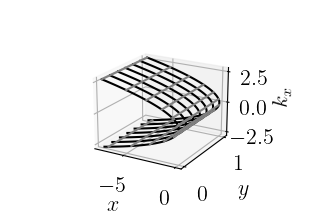

In [85]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(projection='3d')
for i, y0 in enumerate(y):
    ax.plot(rs[:, i, 0, 0], rs[:, i, 0, 1], ks[:, i, 0, 0], 'k-')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$k_x$')
for i in range(0, len(t), int(len(t)/10)):
    ax.plot(rs[i, :, 0, 0], rs[i, :, 0, 1], ks[i, :, 0, 0], '-', color='grey')
ax.view_init(20, -60, 0)
plt.tight_layout()
plt.savefig('./plots/GO_airy_dispersion_manifold.png')
plt.savefig('./plots/GO_airy_dispersion_manifold.pdf')
fig.add_axes([0,0,1,1]).axis("off")
plt.show()

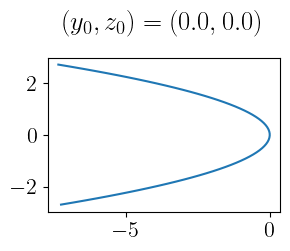

In [52]:
i, j = (0, 0)
plt.figure(figsize=(3,2))
plt.plot(rs[:, 0, 0, 0], ks[:, 0, 0, 0])
plt.title(r'$(y_0, z_0) = (' + str(round(y[i], 2)) + ', ' + str(round(y[j], 2)) + ')$')
plt.show()

In [53]:
rs.shape, ks.shape

((68, 7, 8, 3), (68, 7, 8, 3))

In [357]:
def gram_schmidt_orthogonalize(Q):
    N = Q.shape[-1]
    P = np.zeros(Q.shape)

    def norm(A, i):
        norms = np.sqrt(np_inner_product(A[..., i, :], A[..., i, :]))
        return np.stack([norms]*A.shape[-1], axis=-1)

    P[..., 0, :] = Q[..., 0, :]/norm(Q, 0)
    for k in range(1, N):
        P[..., k, :] = (Q[..., k, :]
                        - sum([(
            np.stack([np_inner_product(Q[..., k, :], P[..., j, :])]*N, axis=-1)
            ) * P[..., j, :] for j in range(k)]))
        P[..., k, :] = P[..., k, :]/norm(P, k)
    return P

In [435]:
ND = rs.shape[-1]
zs = np.concatenate((rs, ks), axis=-1)
gradt_z = fd.grad(zs, t)
norms = np.sqrt(np_inner_product(gradt_z, gradt_z))
T1 = gradt_z/np.stack([norms]*zs.shape[-1], axis=-1) # normalised grad_t z(t, y0, z0)

# Create orthonormal basis starting from single tangent vector
# using Gram Schmidt orthogonalization
eye = np.zeros(np.prod(zs.shape)*zs.shape[-1]).reshape((*zs.shape, zs.shape[-1]))
eye[..., :, :] = np.eye(zs.shape[-1])
ONB = np.copy(eye)
ONB[..., 0, :] = T1
ONB = gram_schmidt_orthogonalize(ONB)

# Tangent space is first 3 vectors of basis:
T = ONB[..., :ND, :]

In [436]:
symplJ = np.copy(ONB)
symplJ[..., :, :] =  np.block([[  np.zeros((ND, ND)), np.eye((ND)) ], [-np.eye(ND), np.zeros((ND, ND))]])

def np_transpose(A):
    '''return transpose of only the last two dimensions.'''
    return np.moveaxis(A, -1, -2)

N = np_transpose(-np.matmul(symplJ, np_transpose(T)))
R = np.concatenate((T, N), axis=-2)

In [437]:
# print(
#     'sample tests of matrices',
#     '\n\n T^T T \n',
#     np.matmul(T, np_transpose(T))[0:3, 0, 0],
#     '\n\n N^T N \n',
#     np.matmul(N, np_transpose(N))[0:3, 0, 0],
#     '\n\n N^T J T \n',
#     np.matmul(N, np.matmul(symplJ, np_transpose(T)))[0:3, 0, 0],
#     '\n\n T^T J T \n',
#     np.round(np.matmul(T, np.matmul(symplJ, np_transpose(T)))[0:3, 0, 0], 4),
# )

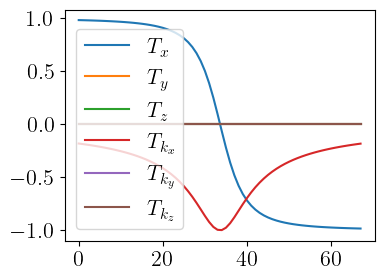

In [438]:
plt.figure(figsize=(4,3))
plt.plot(T1[:, 0, 0, :])
plt.legend([r'$T_{x}$', r'$T_{y}$', r'$T_{z}$', r'$T_{k_x}$', r'$T_{k_y}$', r'$T_{k_z}$'])
plt.show()